In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank_churn.csv.csv to bank_churn.csv (1).csv


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 100)

df = pd.read_csv("bank_churn.csv.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [ ]:
df.isna().sum().sort_values(ascending=False).head(10)


,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
churn_rate = df['Exited'].mean()*100
print(f"Churn rate: {churn_rate:.2f}%")
df['Exited'].value_counts(normalize=True)


Churn rate: 20.38%


,proportion
Exited,
0,0.7962
1,0.2038


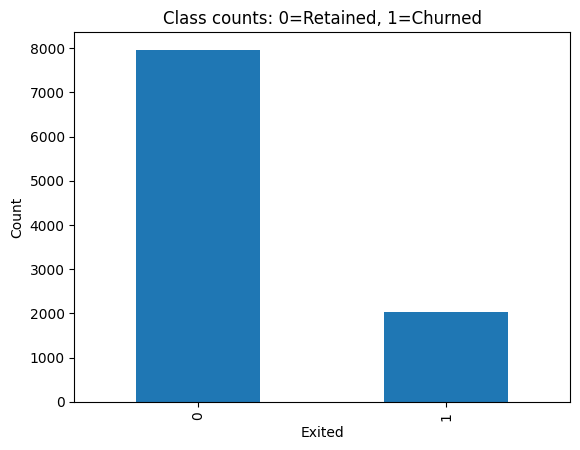

In [ ]:
import matplotlib.pyplot as plt

df['Exited'].value_counts().plot(kind='bar', title='Class counts: 0=Retained, 1=Churned')
plt.xlabel('Exited'); plt.ylabel('Count'); plt.show()


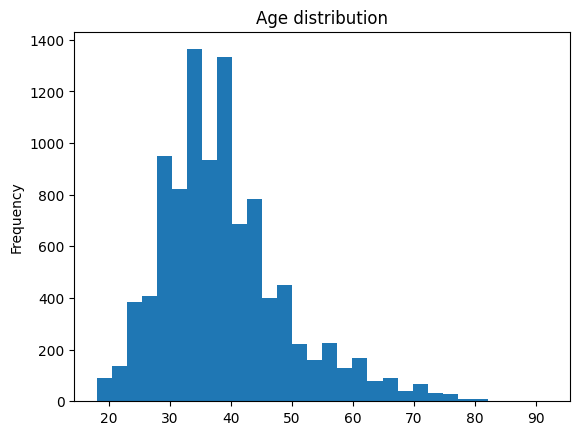

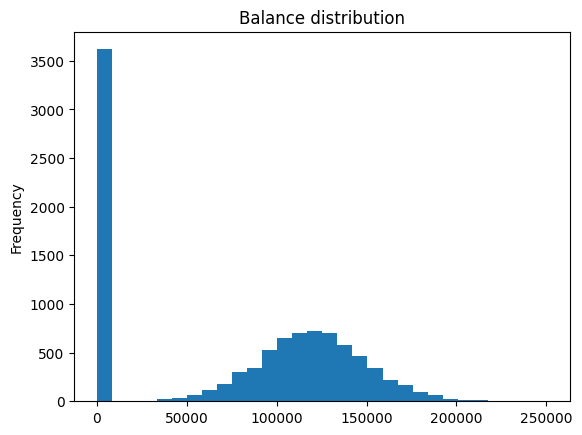

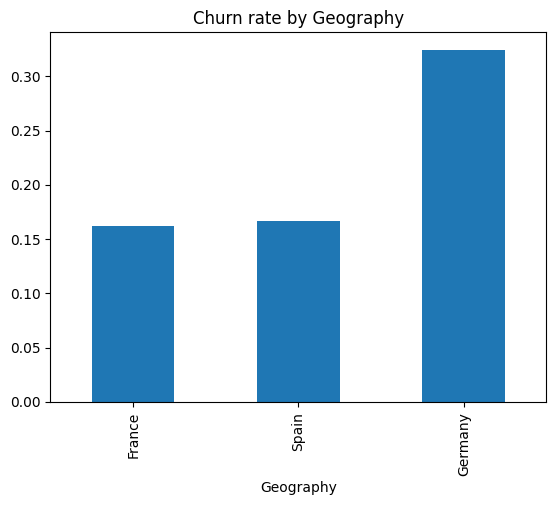

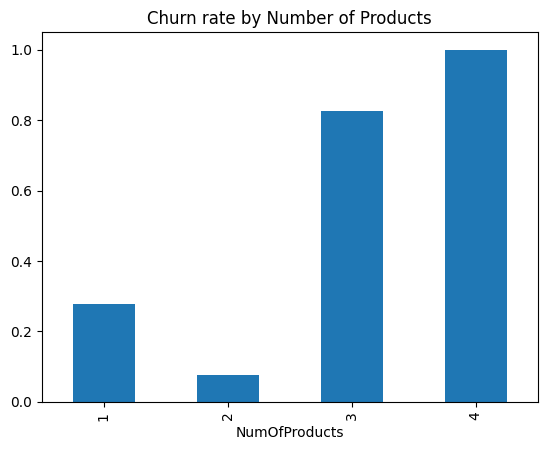

In [ ]:
# Numeric distributions
df['Age'].plot(kind='hist', bins=30, title='Age distribution'); plt.show()
df['Balance'].plot(kind='hist', bins=30, title='Balance distribution'); plt.show()

# Churn rate by categories
df.groupby('Geography')['Exited'].mean().sort_values().plot(kind='bar', title='Churn rate by Geography'); plt.show()
df.groupby('NumOfProducts')['Exited'].mean().plot(kind='bar', title='Churn rate by Number of Products'); plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop pure identifiers
drop_cols = [c for c in ['RowNumber','CustomerId','Surname'] if c in df.columns]
d2 = df.drop(columns=drop_cols)

# Features/target
X = d2.drop(columns=['Exited'])
y = d2['Exited']

# Define columns
cat_cols = [c for c in ['Geography','Gender','Card Type'] if c in X.columns]
num_cols = [c for c in ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard',
                        'IsActiveMember','EstimatedSalary','Complain','Satisfaction Score','Point Earned']
           if c in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

len(X_train), len(X_test)


(8000, 2000)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

logreg = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight=None))
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 0.999196349394029


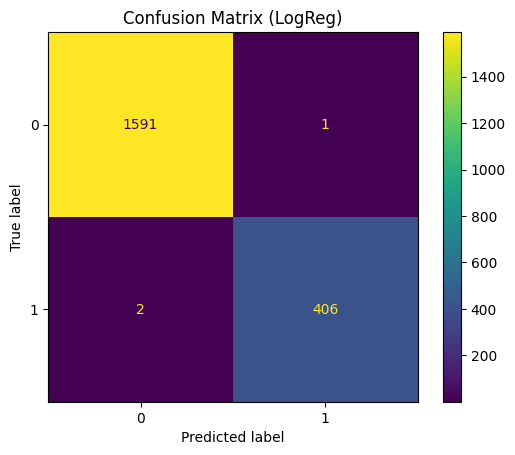

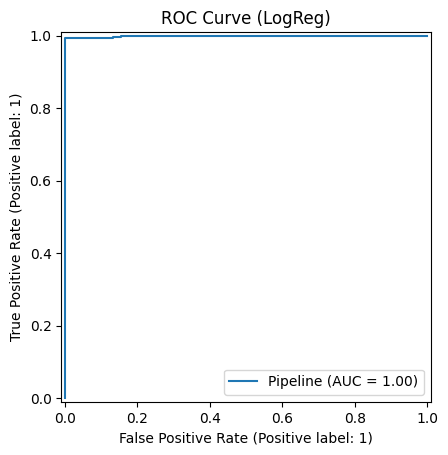

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Confusion Matrix (LogReg)")
plt.show()

RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve (LogReg)")
plt.show()


In [ ]:
import numpy as np

# Get trained OneHot categories to map names
ohe: OneHotEncoder = logreg.named_steps['pre'].transformers_[0][1]
cat_names = []
if hasattr(ohe, 'get_feature_names_out'):
    cat_names = list(ohe.get_feature_names_out(cat_cols))
else:
    # Fallback: generic names
    for c in cat_cols:
        cat_names.extend([f"{c}_{i}" for i in range(len(df[c].unique()))])

feature_names = cat_names + num_cols
coefs = logreg.named_steps['clf'].coef_[0]

# Align lengths just in case
n = min(len(feature_names), len(coefs))
imp = pd.DataFrame({'feature': feature_names[:n], 'coef': coefs[:n]})
imp.sort_values('coef', ascending=False).head(10)


,feature,coef
17,Complain,5.162571
10,Age,0.842630
8,Card Type_SILVER,0.230780
0,Geography_France,0.153102
2,Geography_Spain,0.113863
4,Gender_Male,0.076962
9,CreditScore,0.067107
16,EstimatedSalary,0.031035
12,Balance,0.019445
5,Card Type_DIAMOND,0.011998


In [ ]:
imp.sort_values('coef').head(10)


,feature,coef
15,IsActiveMember,-0.631547
19,Point Earned,-0.398064
1,Geography_Germany,-0.217867
18,Satisfaction Score,-0.210629
6,Card Type_GOLD,-0.098047
7,Card Type_PLATINUM,-0.095633
13,NumOfProducts,-0.088082
11,Tenure,-0.065608
14,HasCrCard,-0.041699
3,Gender_Female,-0.027864


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 0.9987483372746083


In [ ]:
import pandas as pd

def predict_single_customer(model,
                            CreditScore=650, Geography="France", Gender="Male", Age=40,
                            Tenure=5, Balance=60000, NumOfProducts=2, HasCrCard=1,
                            IsActiveMember=1, EstimatedSalary=80000, Complain=0,
                            Satisfaction_Score=3, Card_Type="GOLD", Point_Earned=400):
    """
    Takes a trained model pipeline and one customer's details.
    Returns churn probability (0 to 1).
    """
    sample = pd.DataFrame([{
        "CreditScore": CreditScore,
        "Geography": Geography,
        "Gender": Gender,
        "Age": Age,
        "Tenure": Tenure,
        "Balance": Balance,
        "NumOfProducts": NumOfProducts,
        "HasCrCard": HasCrCard,
        "IsActiveMember": IsActiveMember,
        "EstimatedSalary": EstimatedSalary,
        "Complain": Complain,
        "Satisfaction Score": Satisfaction_Score,
        "Card Type": Card_Type,
        "Point Earned": Point_Earned
    }])

    prob = model.predict_proba(sample)[:,1][0]
    return prob


In [ ]:
prob = predict_single_customer(
    logreg,  # or rf
    CreditScore=720,
    Geography="Germany",
    Gender="Female",
    Age=45,
    Tenure=3,
    Balance=90000,
    NumOfProducts=1,
    HasCrCard=1,
    IsActiveMember=0,
    EstimatedSalary=120000,
    Complain=1,
    Satisfaction_Score=2,
    Card_Type="DIAMOND",
    Point_Earned=500
)
print(f"Predicted churn probability: {prob:.2%}")


Predicted churn probability: 99.82%


In [ ]:
# Rebuild clean features exactly like training
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop pure identifiers
drop_cols = [c for c in ['RowNumber','CustomerId','Surname'] if c in df.columns]
d2 = df.drop(columns=drop_cols).copy()

X = d2.drop(columns=['Exited'])
y = d2['Exited']

cat_cols = [c for c in ['Geography','Gender','Card Type'] if c in X.columns]
num_cols = [c for c in [
    'CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard',
    'IsActiveMember','EstimatedSalary','Complain','Satisfaction Score','Point Earned'
] if c in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='drop'
)

from sklearn.linear_model import LogisticRegression
pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000))])
pipe.fit(X, y)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender',
                                                   'Card Type']),
                                                 ('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary',
                                                   'Complain',
                                                   'Satisfaction Score',
                                                   'Point Earned'])])),
                ('clf', LogisticRegression(max_iter=2000))])

In [ ]:
#  Get predictions on ALL rows & create helper fields for the dashboard -
proba = pipe.predict_proba(X)[:,1]
pred  = (proba >= 0.35).astype(int)   # threshold you can tune in PBI

out = d2.copy()
out['Pred_Prob'] = proba
out['Pred_Label'] = pred  # 1 = predicted churn
out['Actual_Label'] = out['Exited']  # 1 = actually churned

# Helper bands
out['Age Band'] = pd.cut(out['Age'], bins=[0,25,35,45,55,200],
                         labels=['≤25','26–35','36–45','46–55','56+'], right=True)

out['Balance Band'] = pd.cut(out['Balance'], bins=[-1,0,10000,50000,100000,99999999],
                             labels=['0','0–10k','10k–50k','50k–100k','100k+'])

out['Satisfaction Band'] = out['Satisfaction Score'].map({1:'1 - Very Low',2:'2 - Low',3:'3 - Mid',4:'4 - High',5:'5 - Very High'})

out[['Geography','Gender','Age','Age Band','Tenure','Balance','Balance Band',
     'NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Complain',
     'Satisfaction Score','Satisfaction Band','Card Type','Point Earned',
     'Actual_Label','Pred_Prob','Pred_Label']].head()


,Geography,Gender,Age,Age Band,Tenure,Balance,Balance Band,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Satisfaction Band,Card Type,Point Earned,Actual_Label,Pred_Prob,Pred_Label
0,France,Female,42,36–45,2,0.00,0,1,1,1,101348.88,1,2,2 - Low,DIAMOND,464,1,0.996634,1
1,Spain,Female,41,36–45,1,83807.86,50k–100k,1,0,1,112542.58,1,3,3 - Mid,DIAMOND,456,0,0.996911,1
2,France,Female,42,36–45,8,159660.80,100k+,3,1,0,113931.57,1,3,3 - Mid,DIAMOND,377,1,0.998110,1
3,France,Female,39,36–45,1,0.00,0,2,0,0,93826.63,0,5,5 - Very High,GOLD,350,0,0.001244,0
4,Spain,Female,43,36–45,2,125510.82,100k+,1,1,1,79084.10,0,5,5 - Very High,GOLD,425,0,0.000693,0


In [ ]:

out.to_csv('bank_churn_predictions.csv', index=False)
from google.colab import files
files.download('bank_churn_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>